 <div style="text-align: right;">
 2022/06/10 Yuya Saito maid this.
</div>

# Predicting Activity From Fitbit and Apple Watch Data

1. The Goal of this project is to see how accurately various popular classifiers can predict the activity of the participant given both the Fitbit and Apple Watch data.
2. Along the way I will conduct exploratory data analysis (EDA) and look at the predictor space using K-Means Clustering and Principle Component Analysis (PCA). 
3. Finally, I will perform a grid search with a 5 fold cross validation to tune various classifiers and then test the best models on a validation set and display the classification report as well as the confusion matrix.

 <font size="5"> Imports</font> 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
from itertools import product
from typing import Dict, List, Tuple, Union

import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Set Style for Seaborn Plots
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

 <font size="5"> Read in Data</font> 

In [3]:
df=pd.read_csv('./data/aw_fb_data.csv')
df.drop(['Unnamed: 0','X1'],inplace = True , axis =1 )
df.rename({'hear_rate':'heart_rate'},inplace = True, axis =1 )
df.head()

age  gender  height  weight      steps  heart_rate   calories  distance  \
0   20       1   168.0    65.4  10.771429   78.531302   0.344533  0.008327   
1   20       1   168.0    65.4  11.475325   78.453390   3.287625  0.008896   
2   20       1   168.0    65.4  12.179221   78.540825   9.484000  0.009466   
3   20       1   168.0    65.4  12.883117   78.628260  10.154556  0.010035   
4   20       1   168.0    65.4  13.587013   78.715695  10.825111  0.010605   

   entropy_heart  entropy_setps  resting_heart  corr_heart_steps  norm_heart  \
0       6.221612       6.116349           59.0          1.000000   19.531302   
1       6.221612       6.116349           59.0          1.000000   19.453390   
2       6.221612       6.116349           59.0          1.000000   19.540825   
3       6.221612       6.116349           59.0          1.000000   19.628260   
4       6.221612       6.116349           59.0          0.982816   19.715695   

   intensity_karvonen  sd_norm_heart  steps_times_distance       device  \
0            0.138520       1.000000              0.089692  apple watch   
1            0.137967       1.000000              0.102088  apple watch   
2            0.138587       1.000000              0.115287  apple watch   
3            0.139208       1.000000              0.129286  apple watch   
4            0.139828       0.241567              0.144088  apple watch   

  activity  
0    Lying  
1    Lying  
2    Lying  
3    Lying  
4    Lying

 <font size="5"> Feature Engineering</font> 

In [13]:
#Create unique ID to match with person
unique_id_list = ['age','gender','height','weight']
df_person = df[unique_id_list].drop_duplicates()
df_person.reset_index(drop=True,inplace=True)
df_person['person'] = list(range(df_person.shape[0]))
df = pd.merge(df,df_person,on=unique_id_list)
# Calculate Bmi
df['bmi'] = df['weight']/(df['height']**2) * 10_000 
df['calories_bmi'] =df['calories']/df['bmi']

 <font size="5"> Helper Classes And Functions</font> 

In [10]:
# Class to wrap grid_search and create pipeline steps
class ClassifierPipeLine:
    """Class to run gridsearch pipeline for
    classifiers and display confusion matrix and
    classification report.
    """

    def __init__(
        self,
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_test: pd.DataFrame,
        clf,
    ):
        """Initialize Object

        Args:
            X_train (_type_): training predictors
            y_train (_type_): training response
            X_test (_type_): test predictors
            y_test (_type_): test response
            clf (_type_): classifer
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.clf = clf

        self.pipeline = None
        self.grid_cv_fit = None

    def create_pipeline(
        self, steps: Union[List[Tuple[str, str]], None] = None, output: bool = False
    ) -> Union[None, Pipeline]:
        """Takes in steps for pipeline default is set to None
        If no steps are given will use classifier as last step
        automatically.

        Args:
            steps (Union[List[Tuple[str,str]],None], optional): _description_. Defaults to None.
            output (bool, optional): _description_. Defaults to False.

        Returns:
            Union[None,Pipeline]: _description_
        """
        if steps:
            steps.append(("clf", self.clf))
        else:
            steps = [("clf", self.clf)]
        self.pipeline = Pipeline(steps)
        return self.pipeline if output else None

    def create_grid_search(
        self, param_grid: Dict[str, str], cv: int, scoring: str, output: bool = False
    ) -> Union[GridSearchCV, None]:
        """will create a grid search object given params

        Args:
            param_grid (_type_): _description_
            cv (_type_): _description_
            scoring (_type_): _description_
            output (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        model_obj = (
            self.pipeline if self.pipeline else self.create_pipeline(output=True)
        )
        grid_cv = GridSearchCV(model_obj, param_grid=param_grid, cv=cv, scoring=scoring)
        self.grid_cv_fit = grid_cv.fit(self.X_train, self.y_train)
        return self.grid_cv_fit if output else None

    def display_confusion_matrix(
        self, font_scale: float, fig_size: Tuple[int, int]
    ) -> None:
        """Takes in font_scale and fig_size and displays confusion matrix
        of y_test and clf.predict(X_test)

        Args:
            font_scale (float): the font scale
            fig_size (Tuple[int,int]): figsize
        """

        sns.set(font_scale=font_scale)
        fig, ax = plt.subplots(figsize=fig_size)
        cmp = ConfusionMatrixDisplay(
            confusion_matrix(self.y_test, self.grid_cv_fit.predict(self.X_test)),
            display_labels=self.y_test.sort_values().unique(),
        )
        cmp.plot(ax=ax)
        plt.xticks(rotation=45)
        plt.title(f"Confusion Matrix for {type(self.clf).__name__}")
        plt.tight_layout()

    def display_classification_report(self) -> None:
        """Prints Classification Report"""
        print(classification_report(self.y_test, self.grid_cv_fit.predict(self.X_test)))


# strip_box plot
def grid_strip_box(
    rows: int, cols: int, figsize: Tuple[int, int], var_list: List[str], **params
) -> None:
    """Creates a Strip plot inside a box plot
    Used to analyze multiple predictors across target
    levels of activity in facetgrid

    Args:
        rows (int): number of rows
        cols (int): number of columns
        figsize (Tuple[int,int]): figsixe
        var_list (List[str]): list of predictors
    """
    fig, ax = plt.subplots(rows, cols, figsize=figsize)

    # if statement to take care of edge case where ax will not be a tuple
    if (rows > 1) & (cols > 1):
        l1 = list(range(rows))
        l2 = list(range(cols))

        axes_list = list(product(l1, l2))
    else:
        axes_list = list(range(max([rows, cols])))

    for y_var, ax_tup in zip(var_list, axes_list):

        sns.stripplot(
            y=y_var,
            size=5,
            jitter=0.35,
            palette="tab10",
            edgecolor="black",
            linewidth=1,
            ax=ax[ax_tup],
            **params,
        )
        sns.boxplot(y=y_var, palette=["#D3D3D3"], linewidth=5, ax=ax[ax_tup], **params)
        ax[ax_tup].set_title(f"Distribution of {(y_var.replace('_',' ')).title()} by Activity")
        ax[ax_tup].tick_params(axis="x", labelrotation=45)
        plt.tight_layout()
    plt.show()

    # Standard Scaler function


def scale_data(df: pd.DataFrame) -> pd.DataFrame:
    """Function to scale a dataframe

    Args:
        df (pd.DataFrame): Dataframe

    Returns:
        pd.DataFrame: scaled dataframe
    """
    scaler = StandardScaler()
    scaler.fit(df)
    return pd.DataFrame(scaler.transform(df))


# Return inertia for K Means Elbow Plot


def calculate_inertia(k: int, df: pd.DataFrame) -> float:
    """Calculate the intertia from a k means
    used to iterate over array of k values
    for elbow plot

    Args:
        k (int): K in KMeans
        df (pd.DataFrame): Data

    Returns:
        float: inertia
    """
    scaled_df = scale_data(df)
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    return model.inertia_


 <font size="5"> EDA Apple Watch</font> 

In [16]:
df_a = df[df['device']=='apple watch'].copy()
df_a.reset_index(drop=True,inplace=True)
df_a.head()

age  gender  height  weight      steps  heart_rate   calories  distance  \
0   20       1   168.0    65.4  10.771429   78.531302   0.344533  0.008327   
1   20       1   168.0    65.4  11.475325   78.453390   3.287625  0.008896   
2   20       1   168.0    65.4  12.179221   78.540825   9.484000  0.009466   
3   20       1   168.0    65.4  12.883117   78.628260  10.154556  0.010035   
4   20       1   168.0    65.4  13.587013   78.715695  10.825111  0.010605   

   entropy_heart  entropy_setps  ...  intensity_karvonen  sd_norm_heart  \
0       6.221612       6.116349  ...            0.138520       1.000000   
1       6.221612       6.116349  ...            0.137967       1.000000   
2       6.221612       6.116349  ...            0.138587       1.000000   
3       6.221612       6.116349  ...            0.139208       1.000000   
4       6.221612       6.116349  ...            0.139828       0.241567   

   steps_times_distance       device  activity  person_x person_y        bmi  \
0              0.089692  apple watch     Lying         0        0  23.171769   
1              0.102088  apple watch     Lying         0        0  23.171769   
2              0.115287  apple watch     Lying         0        0  23.171769   
3              0.129286  apple watch     Lying         0        0  23.171769   
4              0.144088  apple watch     Lying         0        0  23.171769   

   calories_bmi  person  
0      0.014869       0  
1      0.141881       0  
2      0.409291       0  
3      0.438230       0  
4      0.467168       0  

[5 rows x 23 columns]

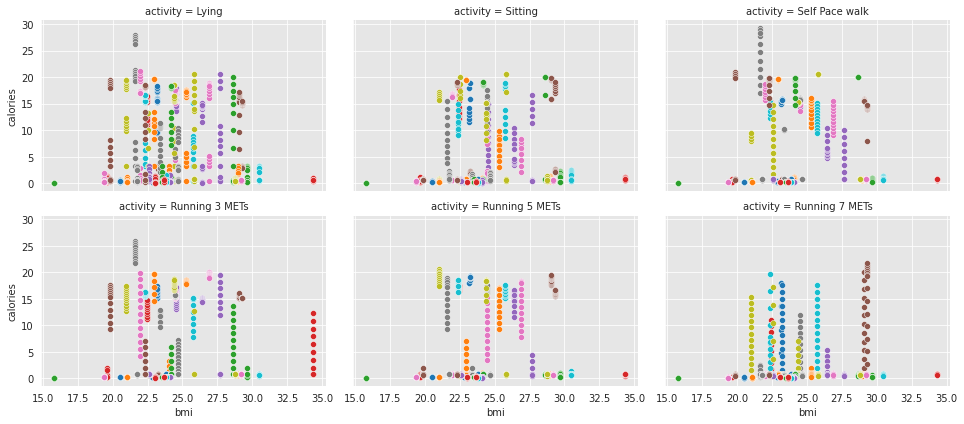

In [19]:
g = sns.FacetGrid(data = df_a, col='activity', col_wrap=3,height=3,aspect=1.5, hue ='person', palette = 'tab10')
g.map(sns.scatterplot,'bmi','calories' )
plt.tight_layout()

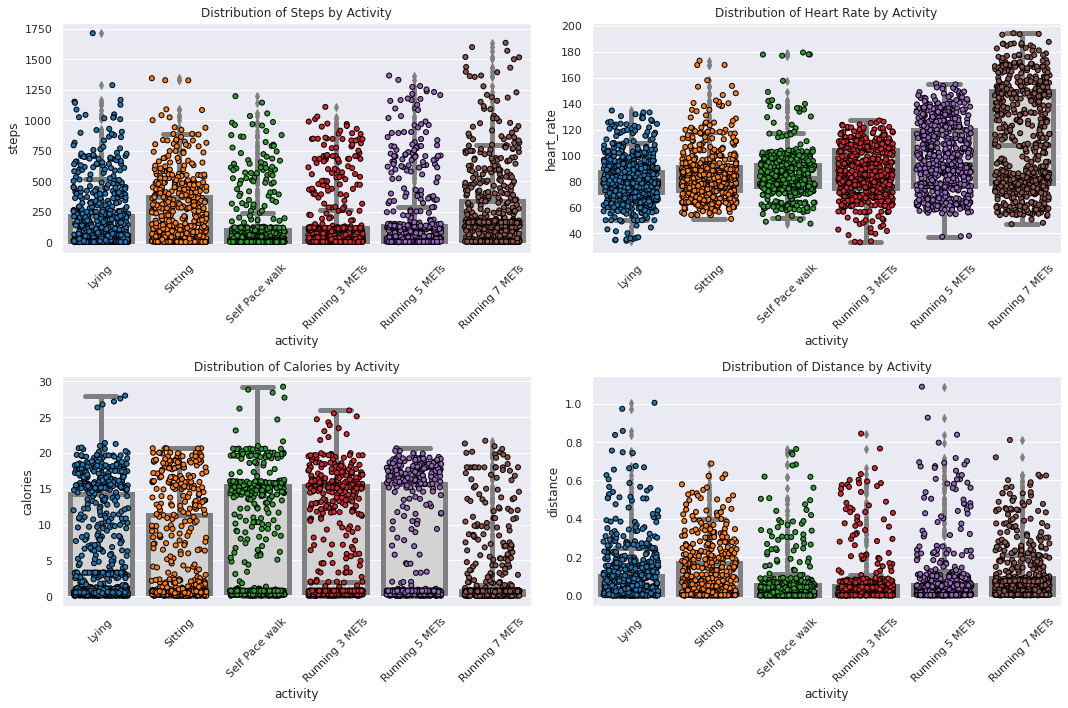

In [20]:
sns.set(font_scale=1)
params = dict(data=df_a,
              x='activity',            
              order=['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs','Running 5 METs', 'Running 7 METs'])
# List of Variables to Compare Distributions
distribution_vars = ['steps', 'heart_rate',
                     'calories','distance',
                     'entropy_heart','calories_bmi',
                     'corr_heart_steps','norm_heart', 
                     'intensity_karvonen','sd_norm_heart', ] 
grid_strip_box(2,2,(15,10),var_list=distribution_vars[0:4],**params)

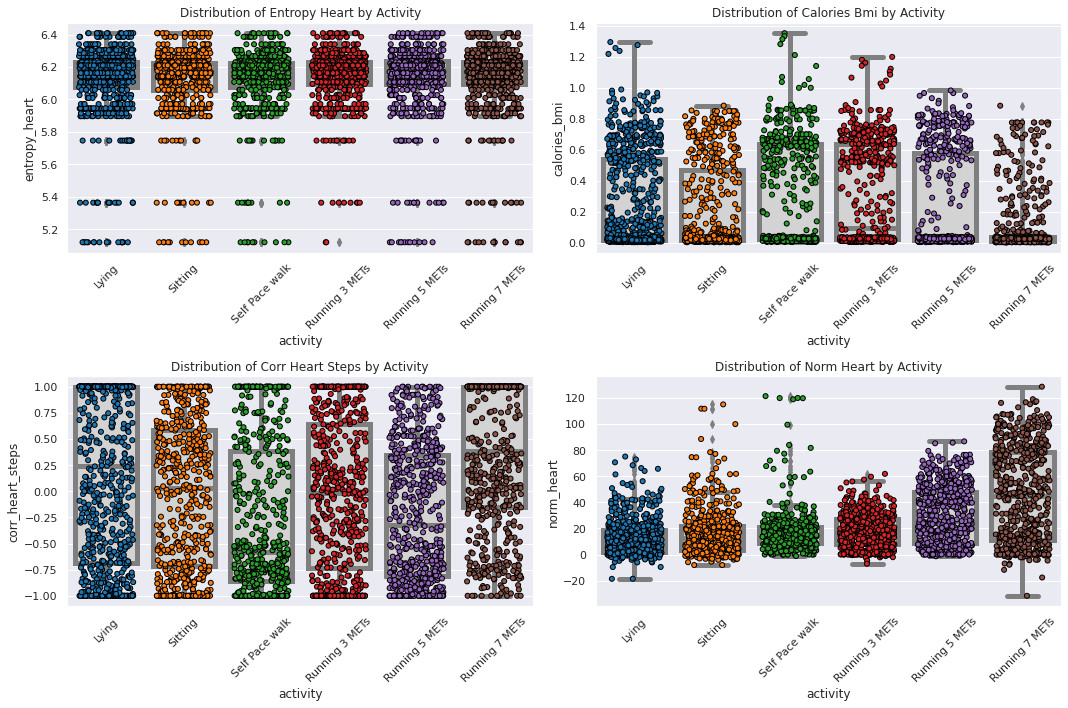

In [21]:
# List of Variables to Compare Distributions
grid_strip_box(2,2,(15,10),var_list=distribution_vars[4:9],**params)

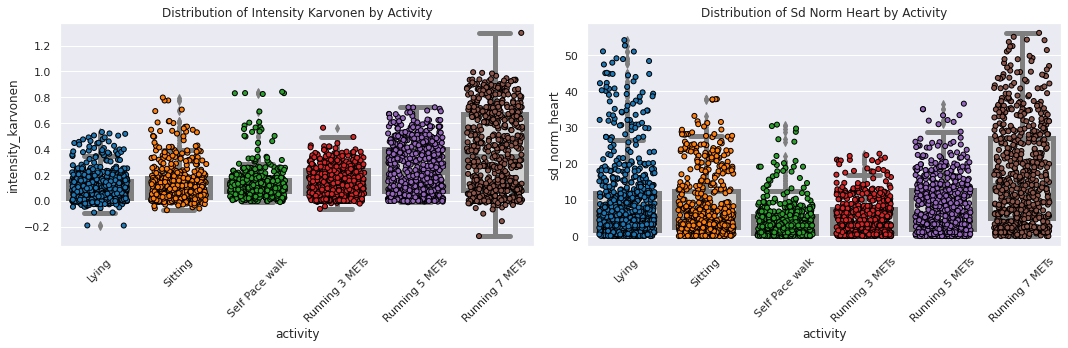

In [22]:
grid_strip_box(1,2,(15,5),var_list=distribution_vars[8:],**params)

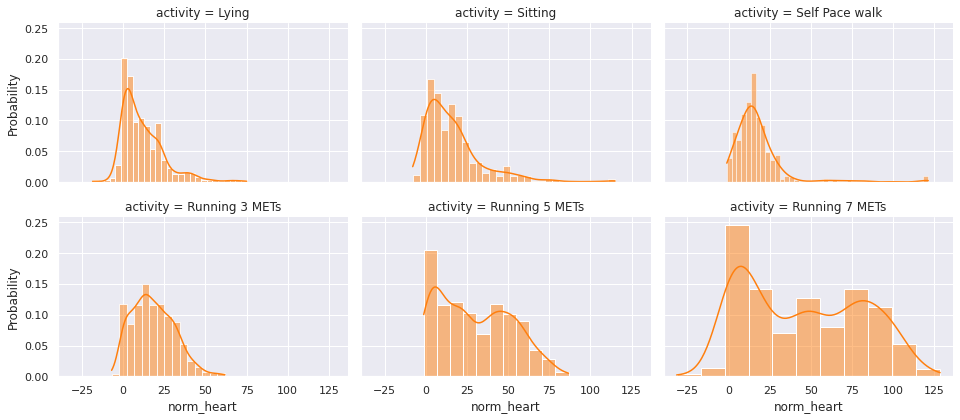

In [23]:
g = sns.FacetGrid(data = df_a,col='activity', col_wrap=3,height=3,aspect=1.5,)
g.map(sns.histplot,'norm_heart', kde =True , color = '#ff7f0e', stat='probability')
plt.tight_layout()

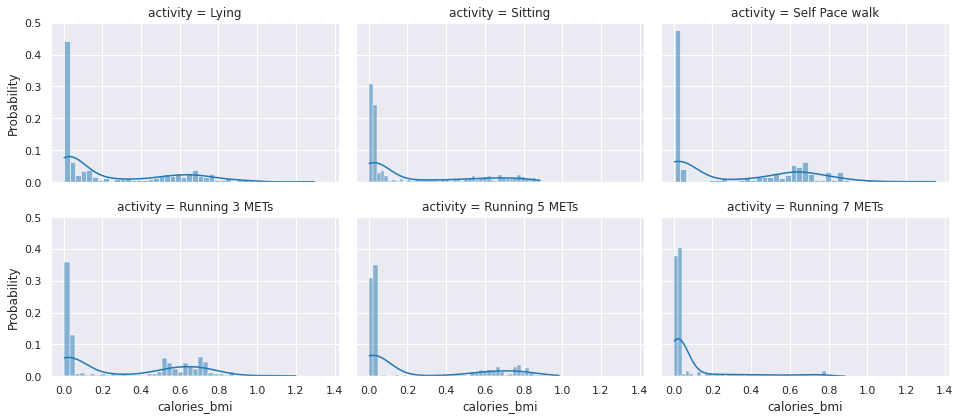

In [25]:
g = sns.FacetGrid(data = df_a,col='activity', col_wrap=3,height=3,aspect=1.5,)
g.map(sns.histplot,'calories_bmi', kde =True , color = '#1f77b4', stat='probability',bins=45)
plt.tight_layout()

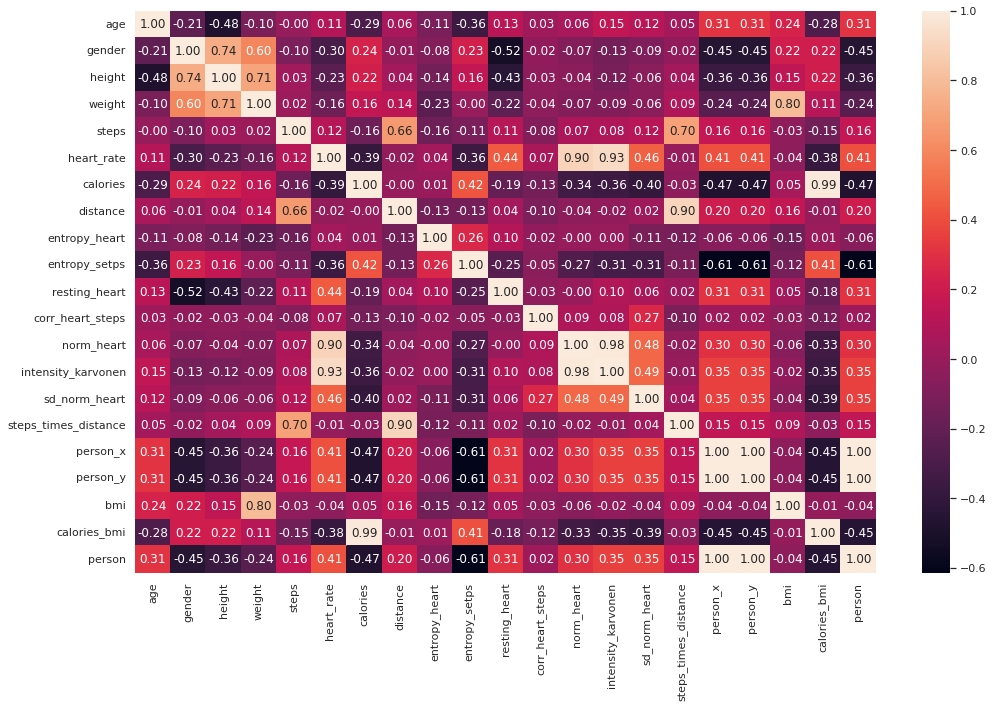

In [26]:
# Correlation
sns.set(font_scale=1)
plt.figure(figsize = (15,10))
sns.heatmap(df_a.corr(),annot=True,fmt='.2f')
plt.tight_layout()

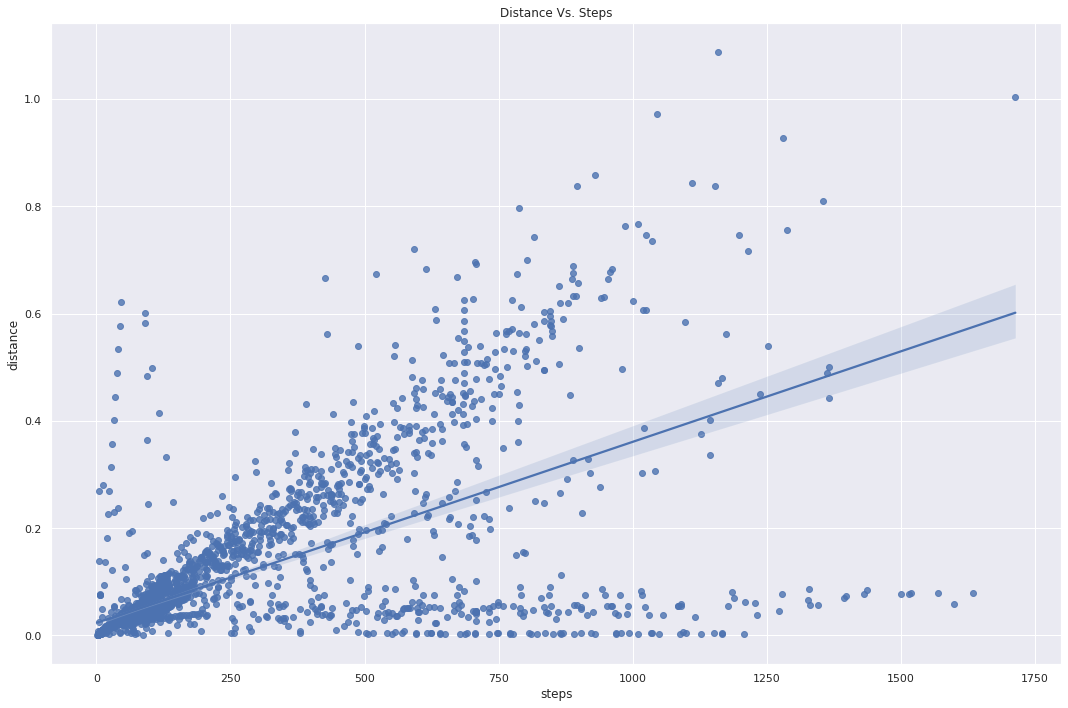

In [27]:
plt.figure(figsize=(15,10))
sns.regplot(data = df_a, x='steps', y='distance')
plt.title('Distance Vs. Steps')
plt.tight_layout()

 <font size="5"> Training and Validation Apple Watch</font> 

In [28]:
# Break into Test Train Split
predictor_list = [col for col in df.columns if col not in ['activity','age', 'gender', 'height', 'weight','person','bmi','device','resting_heart']]
X = df_a[predictor_list]
y = df_a['activity']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3 , random_state = 42 , stratify=y)

 <font size="5"> PCA Apple Watch</font> 

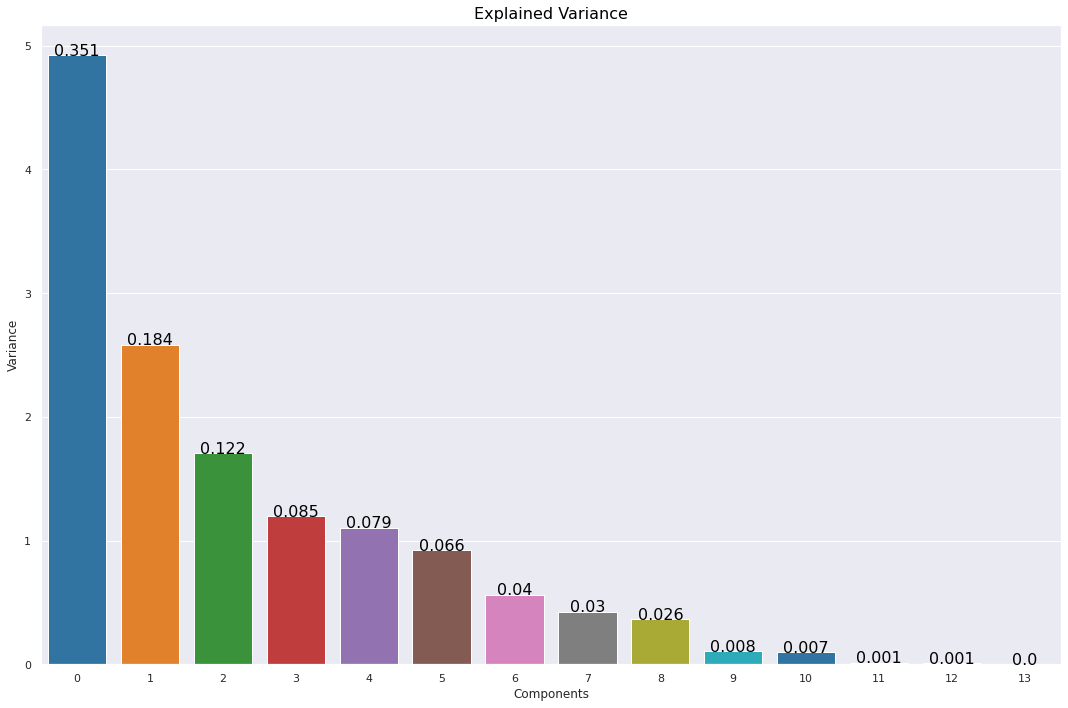

In [30]:
X_train_scaled = scale_data(X_train)
plt.figure(figsize = (15,10))
pca = PCA()
pca.fit(X_train_scaled) 
components = range(pca.n_components_)
plot_comp_df = pd.DataFrame({'Components':components, 'Variance':pca.explained_variance_})
bp = sns.barplot(x = 'Components',y = 'Variance',data = plot_comp_df , palette = 'tab10')
variance_ratios = [round(float(ratio),3) for ratio in pca.explained_variance_ratio_]

font = {'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


for component,variance,ratio in zip(components , pca.explained_variance_ ,variance_ratios):
    bp.text(x=component,y=variance,s=ratio,ha="center",fontdict = font)

plt.title('Explained Variance',fontdict = font)
plt.tight_layout()

In [16]:
np.cumsum(pca.explained_variance_ratio_)

array([0.3379037 , 0.54920335, 0.67697251, 0.7690594 , 0.85277783,
       0.9043518 , 0.95059615, 0.98099062, 0.99022272, 0.99837684,
       0.99934753, 1.        ])

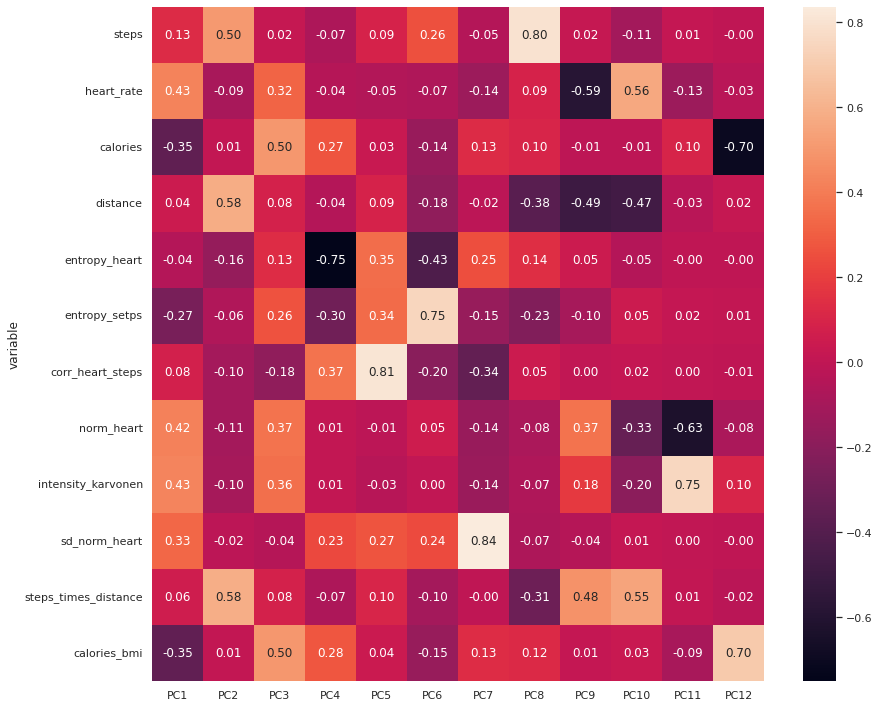

In [17]:
sns.set(font_scale=1)
plt.figure(figsize = (13,10))
loadings = pca.components_
n_comp = pca.n_features_
pc_list = ["PC"+str(i) for i in range(1,n_comp+1)]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X_train.columns.values
loadings_df = loadings_df.set_index('variable')
sns.heatmap(loadings_df ,annot=True,fmt='.2f')
plt.tight_layout()

PCA shows that 6 PCs cover 95% of the variance in the predictor space. 
The PCA correlation plot shows a few mild correlations between the norm_heart predictor, intensity karvonen and the first PC.

 <font size="5"> K-Means Clustering Apple Watch</font> 

In [18]:
k_s = list(range(2,len(y_train.unique() ) + 3))
inertias = [calculate_inertia(k,X_train_scaled) for k in k_s]


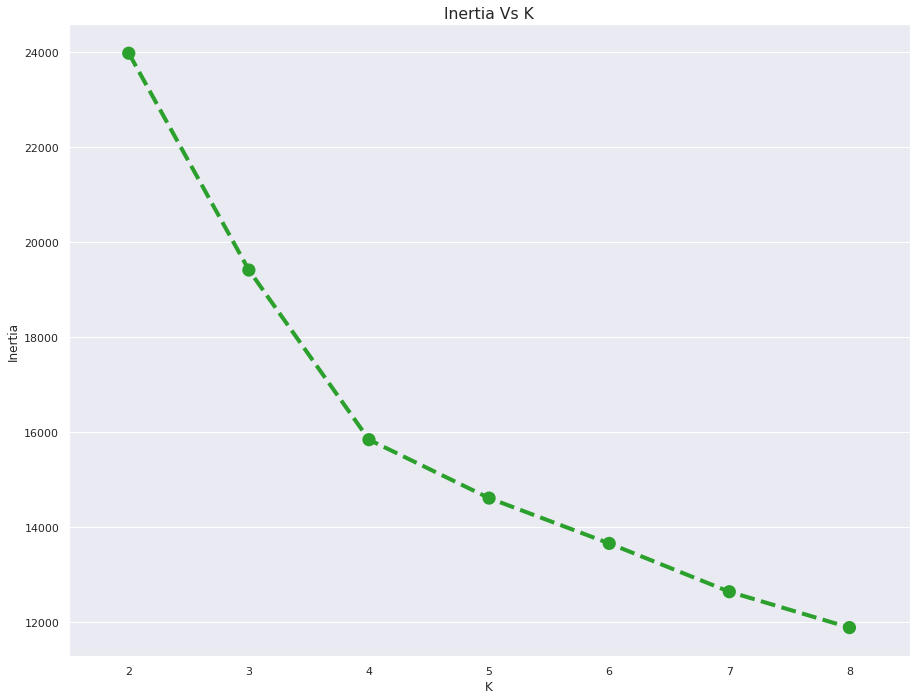

In [19]:
plt.figure(figsize = (13,10))
sns.pointplot(x=k_s,y=inertias , linestyles ='--',markers = 'o',scale=1.5, color='#2ca02c')
sns.set(font_scale=1.3)
plt.title('Inertia Vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.tight_layout()

The inertia elblow plot suggests that 4 would be an ideal number for k on the predictor space.

In [20]:
model_kmeans = KMeans(n_clusters = 4 , random_state=42)
model_kmeans.fit_predict(X_train_scaled)
clusters = pd.Series( model_kmeans.fit_predict(X_train_scaled)).rename('clusters',inplace= True)

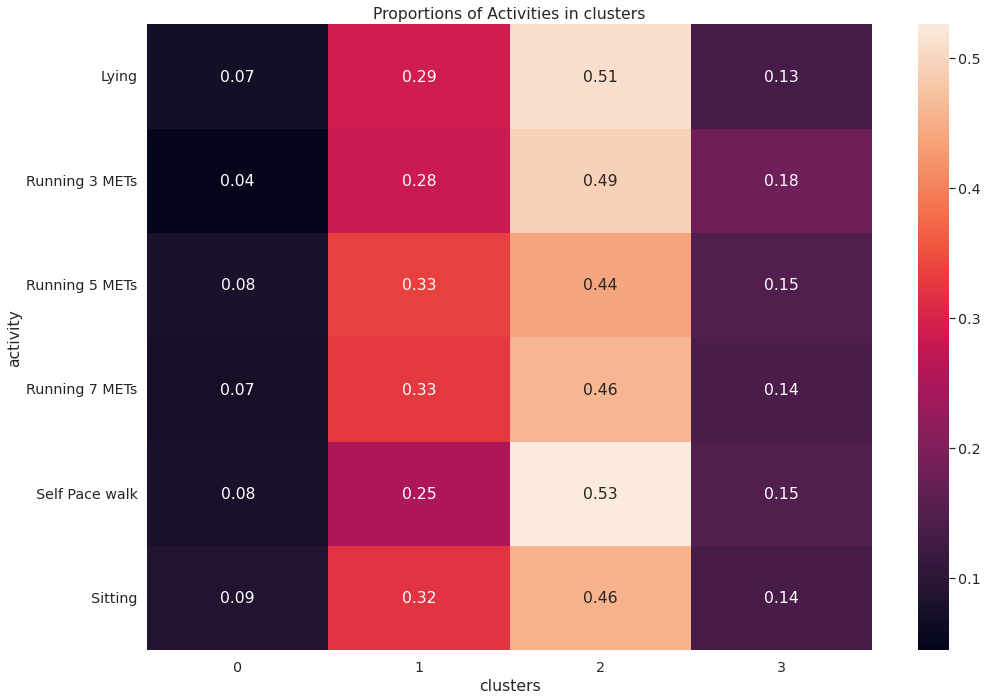

In [21]:
plt.figure(figsize = (15,10))
cross_tab = pd.crosstab(y_train,clusters,normalize=False)
cross_tab.values
row_sums = cross_tab.values.sum(axis=1)
proportions = cross_tab / row_sums.reshape((6,1))
sns.heatmap(proportions,annot=True,fmt='.2f')
plt.title('Proportions of Activities in clusters')
plt.tight_layout()

There does not appear to be a strong relationship between the activities and the clusters from k means as the frequency of each level of activity does not favor any 1 particular cluster.

 <font size="5"> Random Forest Pipeline Apple Watch</font> 

In [22]:
parameters = {'clf__criterion':['entropy','gini'] , 'clf__max_depth':[80,100] , 'clf__n_estimators':[100,120],"clf__max_features":['sqrt', 'log2']}
rf_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,RandomForestClassifier())
grid_cv = rf_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)

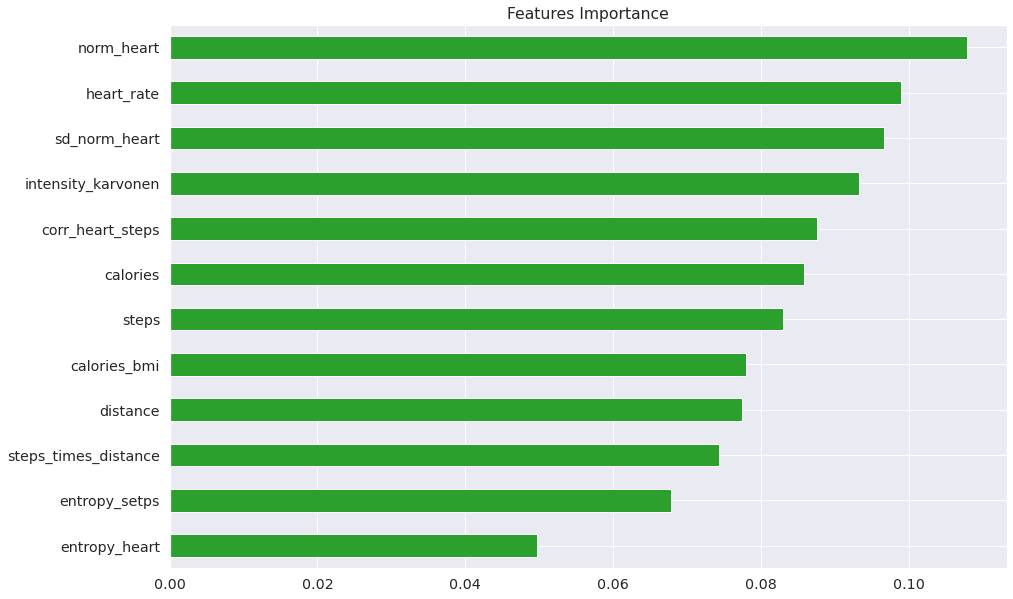

In [23]:
grid_cv.best_params_
rf_params = {key[5:]:val for key,val in grid_cv.best_params_.items()}
rf = RandomForestClassifier()
rf.set_params(**rf_params)
rf.fit(X_train,y_train)

importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize = (15,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='#2ca02c')
plt.title('Features Importance')
plt.show()

In [24]:
rf_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.76      0.81      0.78       236
Running 3 METs       0.86      0.86      0.86       172
Running 5 METs       0.83      0.86      0.85       181
Running 7 METs       0.91      0.88      0.90       184
Self Pace walk       0.84      0.83      0.84       159
       Sitting       0.75      0.69      0.72       165

      accuracy                           0.82      1097
     macro avg       0.83      0.82      0.82      1097
  weighted avg       0.82      0.82      0.82      1097



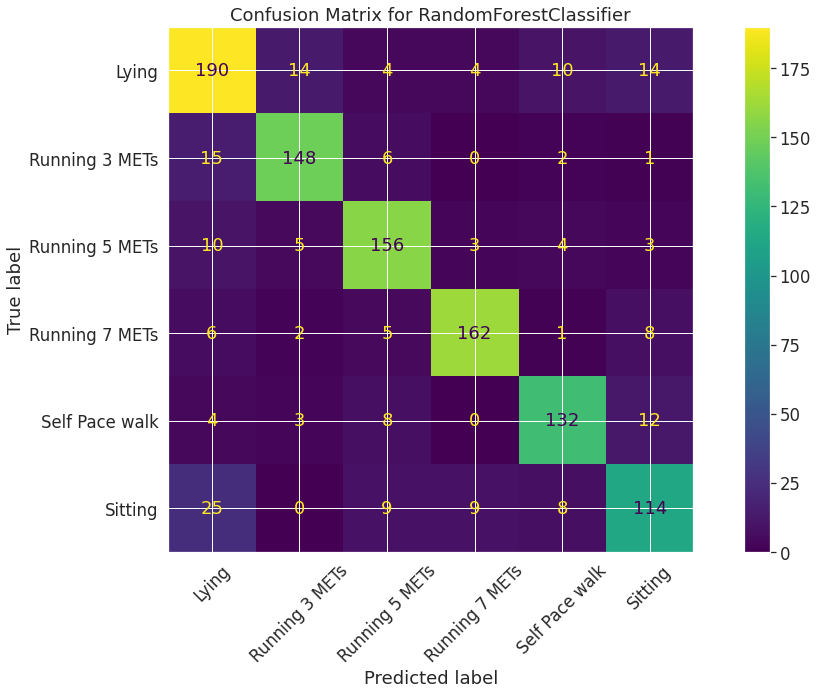

In [25]:
rf_model.display_confusion_matrix(font_scale=1.5,fig_size=(15,10))

The Random Forest had an 82 percent accuracy and had 0.90 precision and 0.88 recall on the Running 7 Mets category.
Additionally, for Apple Watch data the variable importance favored the variables related to heart rate. It will be interesting to see if this holds for Fitbit data as well.

 <font size="5"> KNN Pipeline Apple Watch</font> 

In [26]:
parameters = {'clf__n_neighbors':list(range(3,15,1)),'clf__metric':['euclidean']}
steps = [('scale',StandardScaler()),('KNN',KNeighborsClassifier())]

knn_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,KNeighborsClassifier())
knn_model.create_pipeline()
grid_cv = knn_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)


In [27]:
knn_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.52      0.66      0.58       236
Running 3 METs       0.65      0.74      0.69       172
Running 5 METs       0.63      0.67      0.65       181
Running 7 METs       0.72      0.61      0.66       184
Self Pace walk       0.71      0.61      0.66       159
       Sitting       0.50      0.35      0.41       165

      accuracy                           0.61      1097
     macro avg       0.62      0.61      0.61      1097
  weighted avg       0.62      0.61      0.61      1097



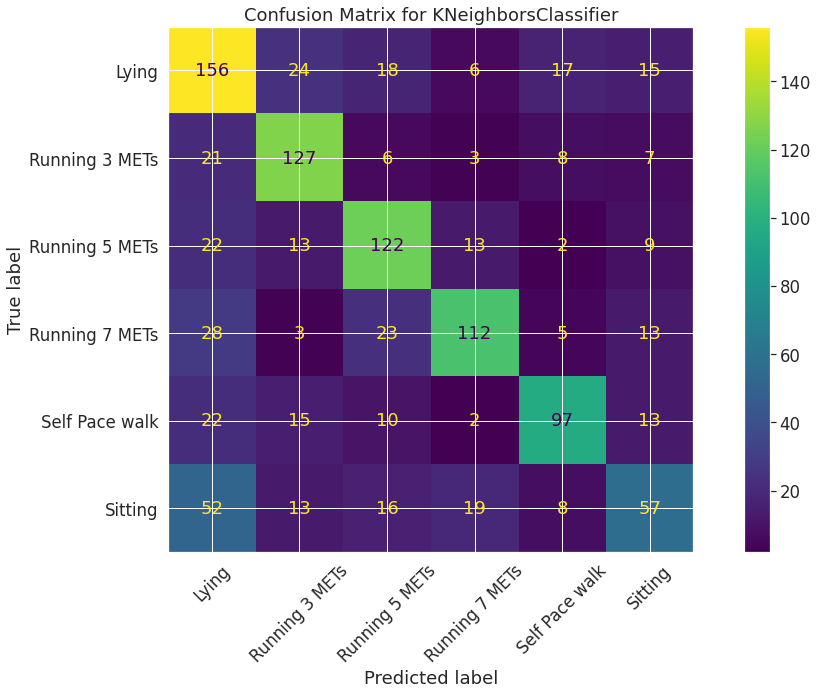

In [28]:
knn_model.display_confusion_matrix(font_scale=1.5,fig_size=(15,10))

Knn shows a 61 percent accuracy which is much lower than the Random Forest.

 <font size="5"> NB Pipeline Apple Watch</font> 

In [29]:
parameters = {'clf__var_smoothing':[1e-9,1e-8,1e-7]}
steps = [('scale',StandardScaler())]
nb_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,GaussianNB())
nb_model.create_pipeline(steps = steps)
grid_cv = nb_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)

In [30]:
nb_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.39      0.38      0.39       236
Running 3 METs       0.25      0.17      0.21       172
Running 5 METs       0.27      0.08      0.13       181
Running 7 METs       0.46      0.53      0.49       184
Self Pace walk       0.26      0.69      0.37       159
       Sitting       0.19      0.06      0.09       165

      accuracy                           0.32      1097
     macro avg       0.30      0.32      0.28      1097
  weighted avg       0.31      0.32      0.29      1097



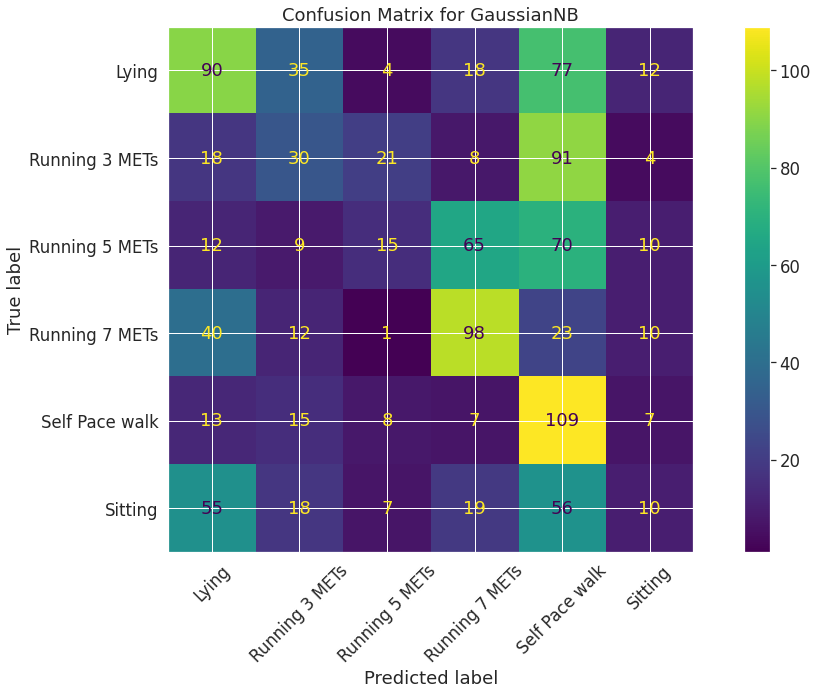

In [31]:
nb_model.display_confusion_matrix(font_scale=1.5,fig_size=(15,10))

The Naive Bayes Classifier shows a mere 32% accuracy which is worse than both KNN and Random Forest. It appears this data does not do as well with traditional statistics based approaches. Next I will try a Gradient Boost Classifier.

 <font size="5"> Gradient Boost Pipeline Apple Watch</font> 

In [32]:
parameters = {'clf__n_estimators':[200,250] , 'clf__learning_rate':[0.5,0.1],'clf__max_features':["sqrt"], 'clf__max_depth':[10,5]}
g_boost_clf = GradientBoostingClassifier()
g_boost_model = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,g_boost_clf)
g_boost_model.create_pipeline()
grid_cv = g_boost_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)


In [33]:
g_boost_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.79      0.81      0.80       236
Running 3 METs       0.86      0.86      0.86       172
Running 5 METs       0.85      0.85      0.85       181
Running 7 METs       0.90      0.90      0.90       184
Self Pace walk       0.86      0.83      0.84       159
       Sitting       0.71      0.71      0.71       165

      accuracy                           0.83      1097
     macro avg       0.83      0.83      0.83      1097
  weighted avg       0.83      0.83      0.83      1097



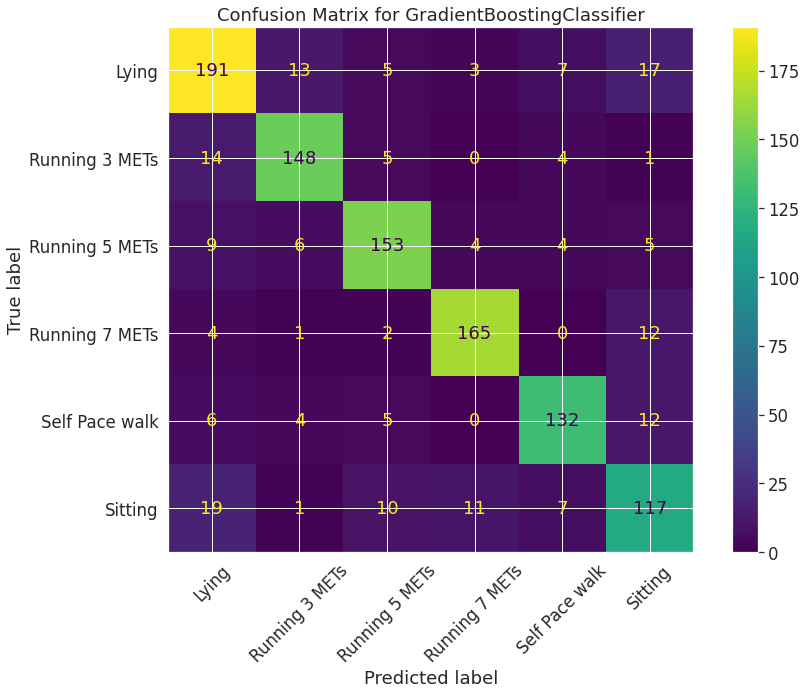

In [34]:
g_boost_model.display_confusion_matrix(font_scale=1.5,fig_size=(13,10))

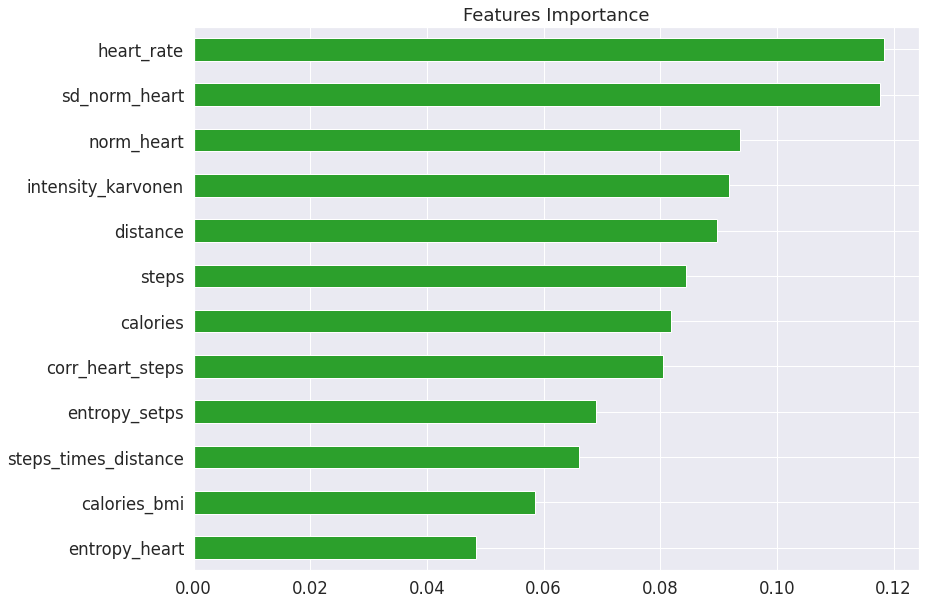

In [35]:
grid_cv.best_params_
gb_params = {key[5:]:val for key,val in grid_cv.best_params_.items()}
gb = GradientBoostingClassifier()
gb.set_params(**gb_params)
gb.fit(X_train,y_train)

importances = pd.Series(data=gb.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize = (13,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='#2ca02c')
plt.title('Features Importance')
plt.show()

Gradient Boost shows an 84% accuracy with a 0.93 Precision and 0.89 recall on Running 7 Mets. 
Feature Importance also shows the heart rate variables as the ones with the highest feature importance.

 <font size="5"> EDA Fitbit</font> 

In [36]:
df_f = df[df['device'] == 'fitbit'].copy()
df_f.reset_index(drop=True,inplace=True)

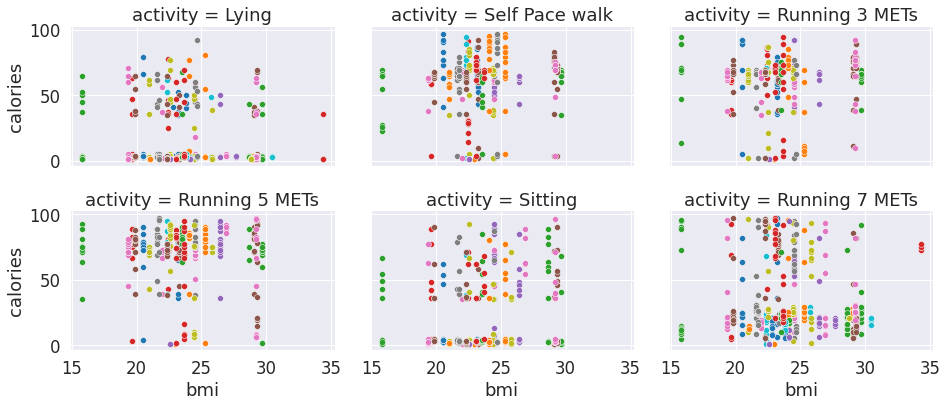

In [37]:
g = sns.FacetGrid(data = df_f,col='activity', col_wrap=3,height=3,aspect=1.5,hue = 'person',palette = 'tab10')
g.map(sns.scatterplot,'bmi','calories' )
plt.tight_layout()

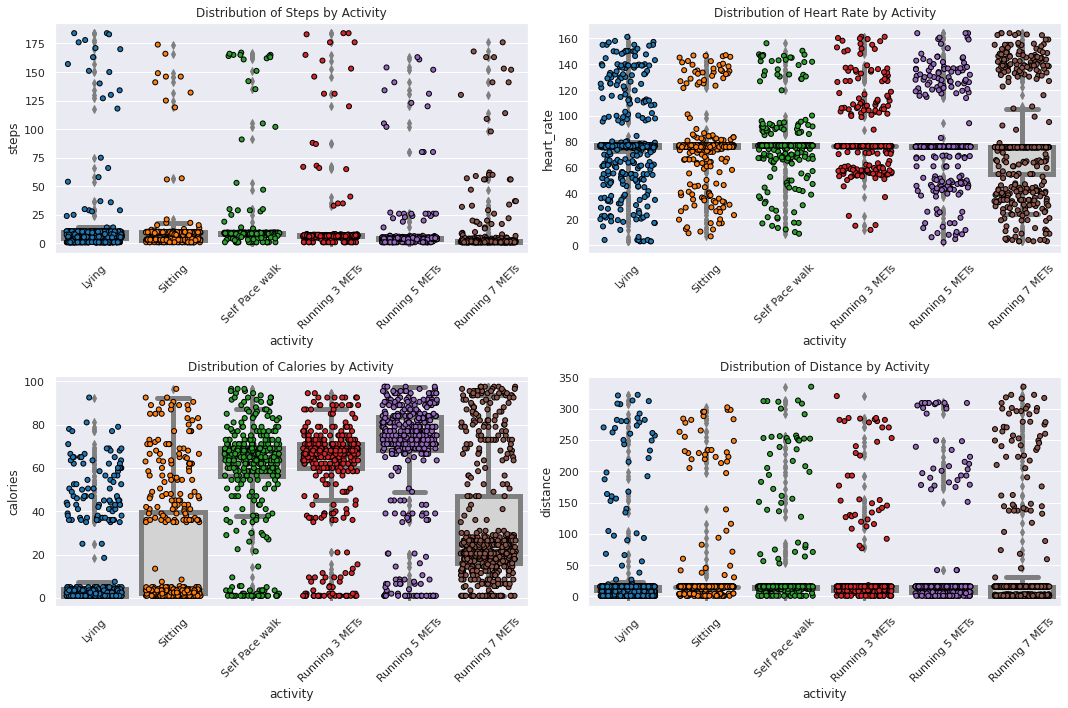

In [38]:
sns.set(font_scale=1)
params = dict(data=df_f,
              x='activity',            
              order=['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs','Running 5 METs', 'Running 7 METs'])
# List of Variables to Compare Distributions
distribution_vars = ['steps', 'heart_rate',
                     'calories','distance',
                     'entropy_heart','calories_bmi',
                     'corr_heart_steps','norm_heart', 
                     'intensity_karvonen','sd_norm_heart', ] 
grid_strip_box(2,2,(15,10),var_list=distribution_vars[0:4],**params)

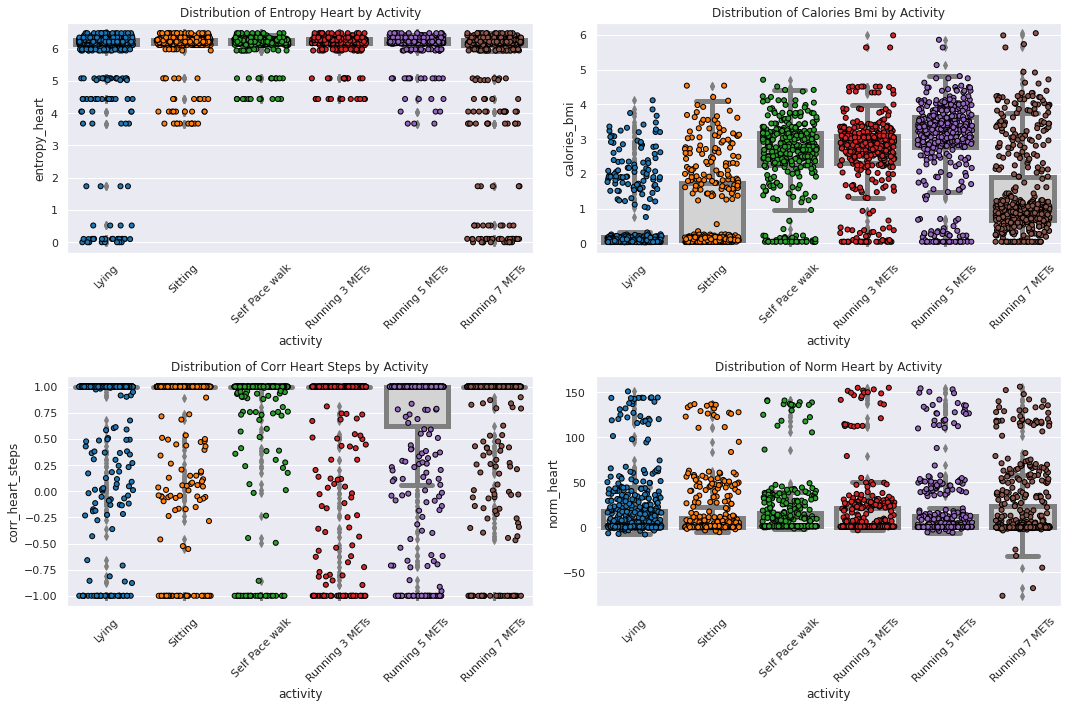

In [39]:
grid_strip_box(2,2,(15,10),var_list=distribution_vars[4:9],**params)

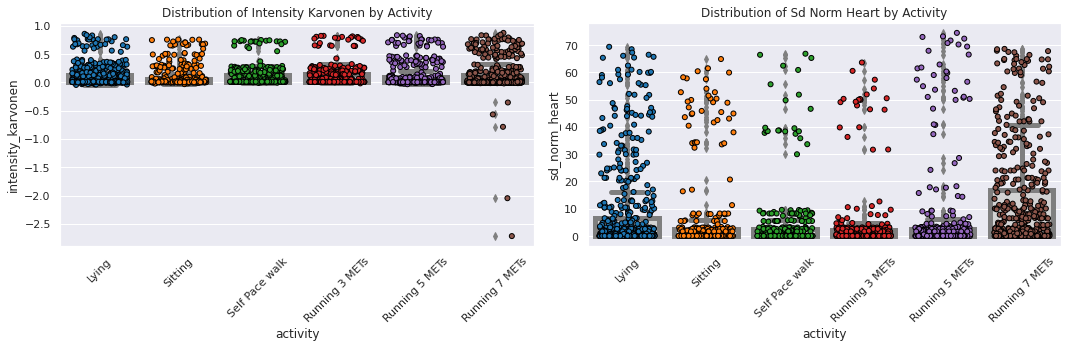

In [40]:
grid_strip_box(1,2,(15,5),var_list=distribution_vars[8:],**params)

Interestingly, the Fitbit data seems to show more separation on calories, distance and steps across the activities where Apple Watch showed heart rate to be a stronger separator.

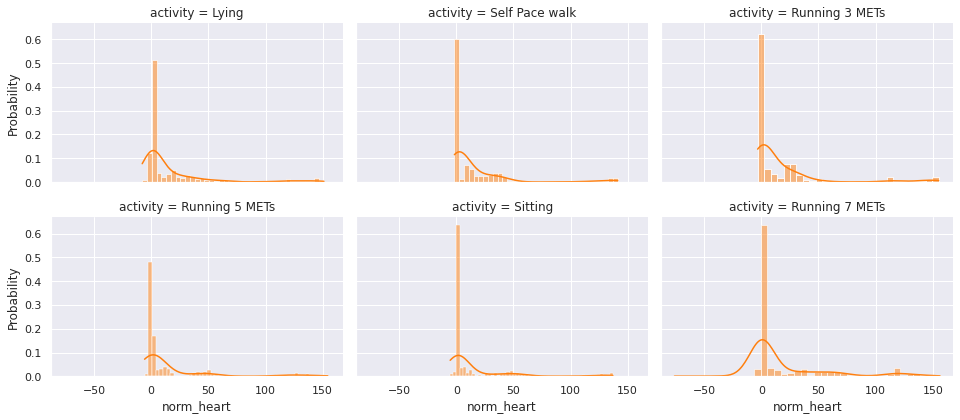

In [41]:
g = sns.FacetGrid(data = df_f,col='activity', col_wrap=3,height=3,aspect=1.5,)
g.map(sns.histplot,'norm_heart', kde =True , color = '#ff7f0e', stat='probability')
plt.tight_layout()

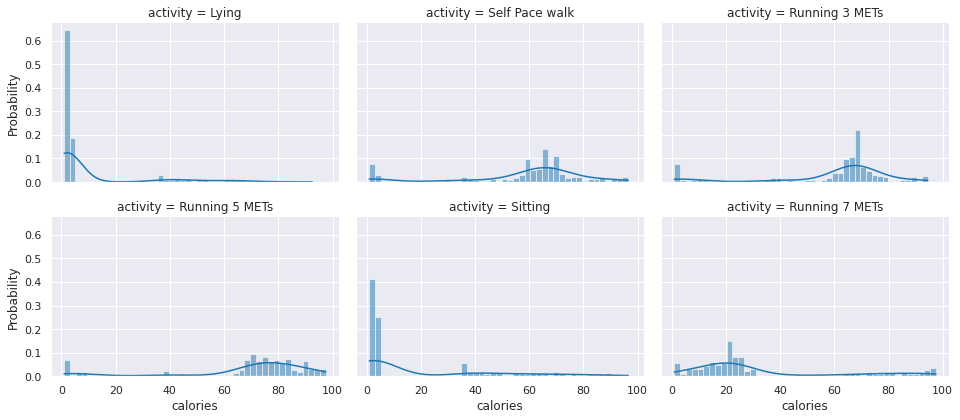

In [42]:
g = sns.FacetGrid(data = df_f,col='activity', col_wrap=3,height=3,aspect=1.5,)
g.map(sns.histplot,'calories', kde =True , color = '#1f77b4', stat='probability',bins=45)
plt.tight_layout()

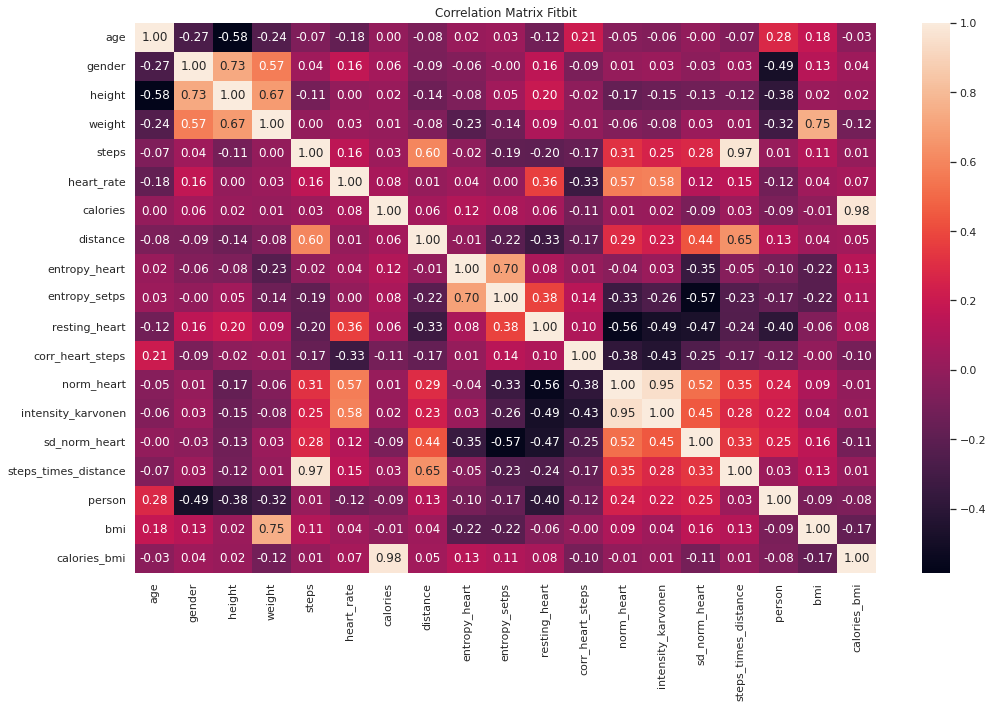

In [43]:
sns.set(font_scale=1)
plt.figure(figsize = (15,10))
sns.heatmap(df_f.corr(),annot=True,fmt='.2f')
plt.title('Correlation Matrix Fitbit')
plt.tight_layout()

Distance and steps show a weaker correlation on the Fitbit data. Looking at the data, it also appears the units on distance and steps are different between the 2 devices.

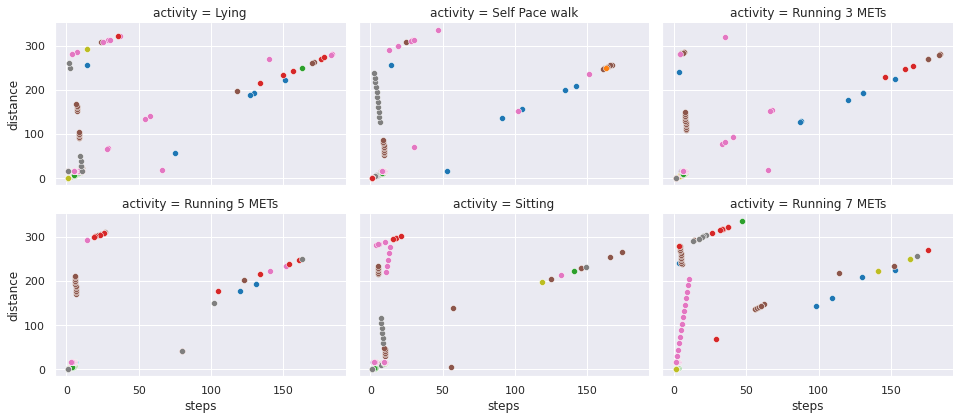

In [44]:
g = sns.FacetGrid(data = df_f,col='activity', col_wrap=3,height=3,aspect=1.5,hue = 'person',palette = 'tab10')
g.map(sns.scatterplot,'steps','distance' )
plt.tight_layout()

It looks like in some of the Fitbit data there is some of the positive correlation we would expect to see, but it also looks like there is a lot of noise.

 <font size="5"> Training and Validation Fitbit</font> 

In [45]:
predictor_list = [col for col in df_f.columns if col not in ['activity','age', 'gender', 'height', 'weight','bmi','device','person','resting_heart']]

X = df_f[predictor_list]
y = df_f['activity']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3 , random_state = 42 , stratify=y)


 <font size="5"> PCA Fitbit</font> 

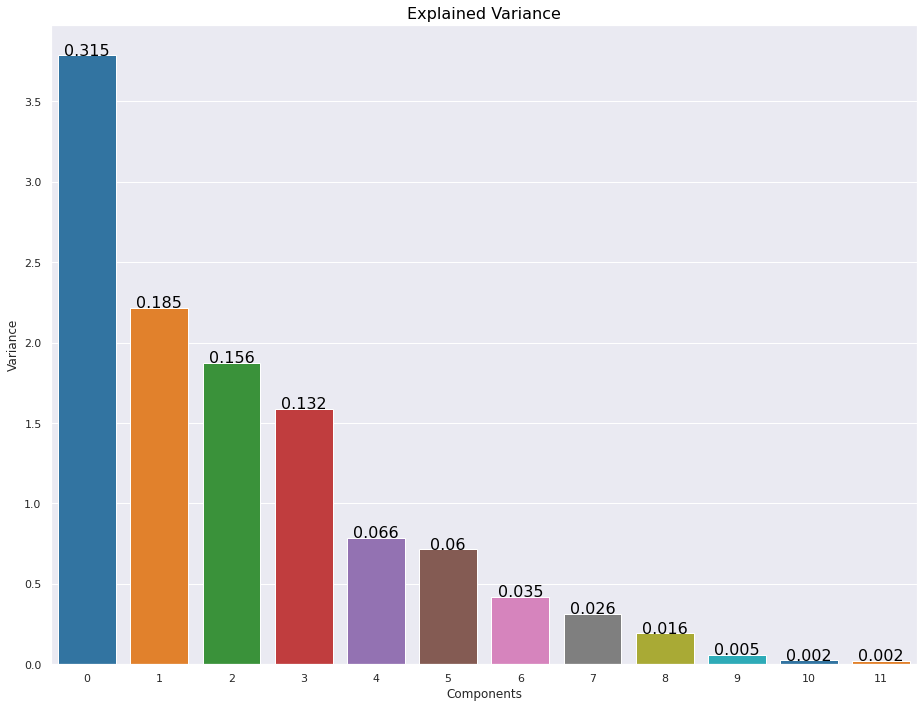

In [46]:
X_train_scaled = scale_data(X_train)
from sklearn.decomposition import PCA
plt.figure(figsize = (13,10))
pca = PCA()
pca.fit(scale_data(X_train_scaled)) 
components = range(pca.n_components_)
plot_comp_df = pd.DataFrame({'Components':components, 'Variance':pca.explained_variance_})
bp = sns.barplot(x = 'Components',y = 'Variance',data = plot_comp_df , palette = 'tab10')
variance_ratios = [round(float(ratio),3) for ratio in pca.explained_variance_ratio_]

font = {'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


for component,variance,ratio in zip(components , pca.explained_variance_ ,variance_ratios):
    bp.text(x=component,y=variance,s=ratio,ha="center",fontdict = font)

plt.title('Explained Variance',fontdict = font)
plt.tight_layout()

In [47]:
np.cumsum(pca.explained_variance_ratio_)

array([0.31546937, 0.50021508, 0.6563211 , 0.7886822 , 0.85432417,
       0.9139484 , 0.94889331, 0.97503234, 0.99117382, 0.99599579,
       0.99808874, 1.        ])

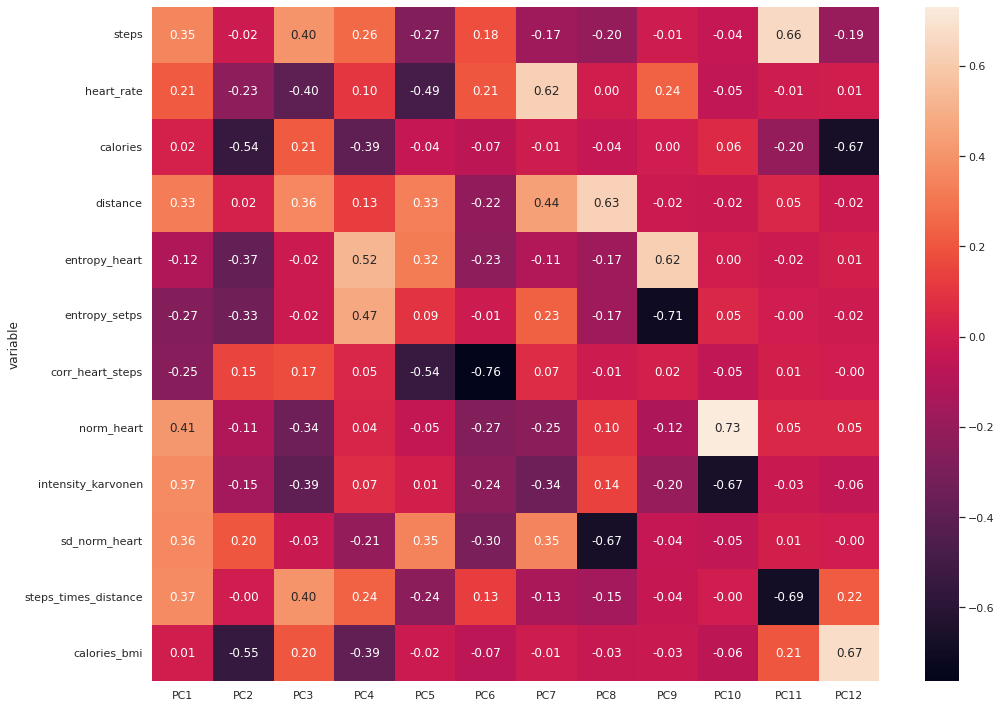

In [48]:
sns.set(font_scale=1)
plt.figure(figsize = (15,10))
loadings = pca.components_
n_comp = pca.n_features_
pc_list = ["PC"+str(i) for i in range(1,n_comp+1)]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X_train.columns.values
loadings_df = loadings_df.set_index('variable')
sns.heatmap(loadings_df ,annot=True,fmt='.2f')
plt.tight_layout()

From PCA we see about 95% of the variance in the predictor space is taken care of in the first 6 PCs. We also see norm_hear and intensity karvonen correlate strongest with PC1

 <font size="5"> K Means Fitbit</font> 

In [49]:
k_s = list(range(2,len(y_train.unique() ) + 3))
inertias = [calculate_inertia(k,X_train_scaled) for k in k_s]

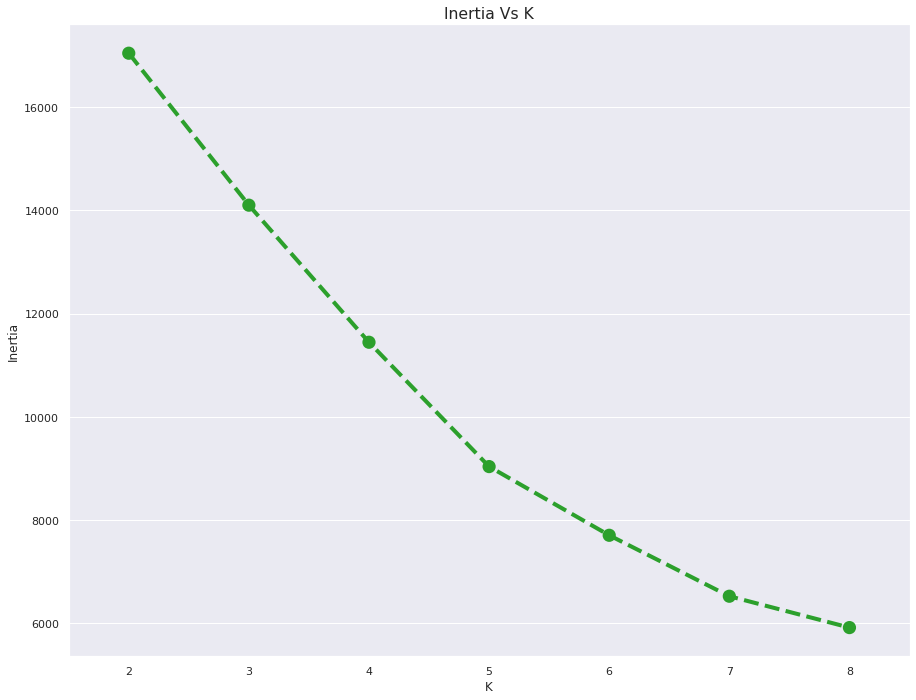

In [50]:
plt.figure(figsize = (13,10))
sns.pointplot(x=k_s,y=inertias , linestyles ='--',markers = 'o',scale=1.5, color='#2ca02c')
sns.set(font_scale=1.3)
plt.title('Inertia Vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.tight_layout()

In [51]:
model_kmeans = KMeans(n_clusters = 5 , random_state=40)
model_kmeans.fit_predict(X_train_scaled)
clusters = pd.Series( model_kmeans.fit_predict(X_train_scaled)).rename('clusters',inplace= True)

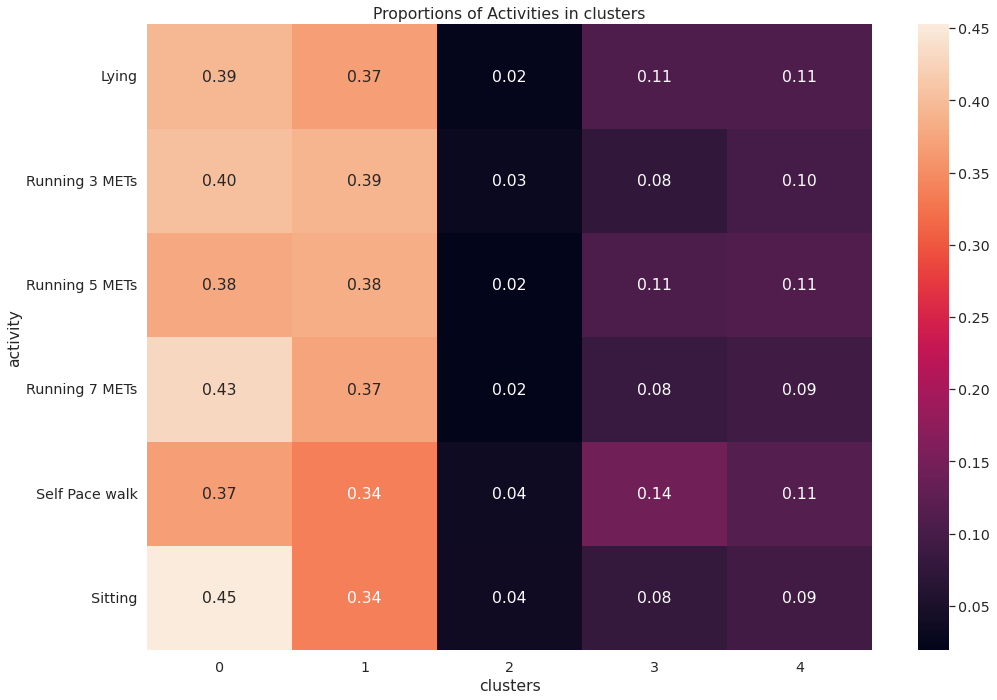

In [52]:
plt.figure(figsize = (15,10))
cross_tab = pd.crosstab(y_train,clusters,normalize=False)
row_sums = cross_tab.values.sum(axis=1)
proportions = cross_tab / row_sums.reshape((6,1))
sns.heatmap(proportions,annot=True,fmt='.2f')
plt.title('Proportions of Activities in clusters')
plt.tight_layout()

From the Elbow plot of the inertia score it looks like 5 cluster is ideal. From the cluster crosstab It does look like the Lying activity lines up slightly more with cluster 1.

 <font size="5"> Random Forest Pipeline Fitbit</font> 

In [53]:
parameters = {'clf__criterion':['entropy','gini'] , 'clf__max_depth':[80,100] , 'clf__n_estimators':[100,120],"clf__max_features":['sqrt', 'log2']}
rf_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,RandomForestClassifier())
grid_cv = rf_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)

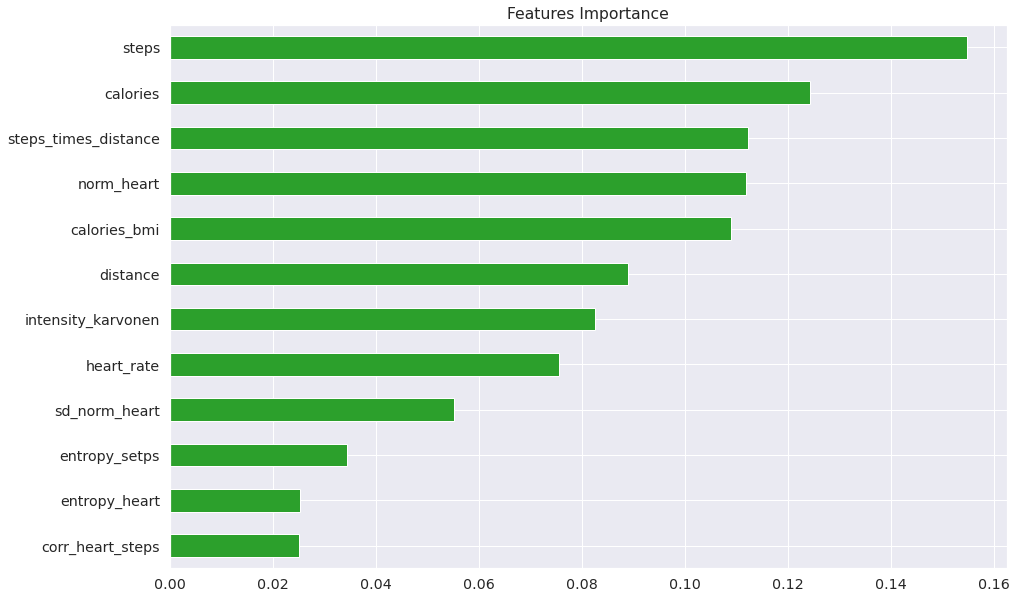

In [54]:
grid_cv.best_params_
rf_params = {key[5:]:val for key,val in grid_cv.best_params_.items()}
rf = RandomForestClassifier()
rf.set_params(**rf_params)
rf.fit(X_train,y_train)

importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize = (15,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='#2ca02c')
plt.title('Features Importance')
plt.show()

In [55]:
rf_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.83      0.85      0.84       178
Running 3 METs       0.89      0.92      0.91       114
Running 5 METs       0.90      0.92      0.91       120
Running 7 METs       0.97      0.93      0.95       150
Self Pace walk       0.86      0.86      0.86       108
       Sitting       0.83      0.80      0.81       113

      accuracy                           0.88       783
     macro avg       0.88      0.88      0.88       783
  weighted avg       0.88      0.88      0.88       783



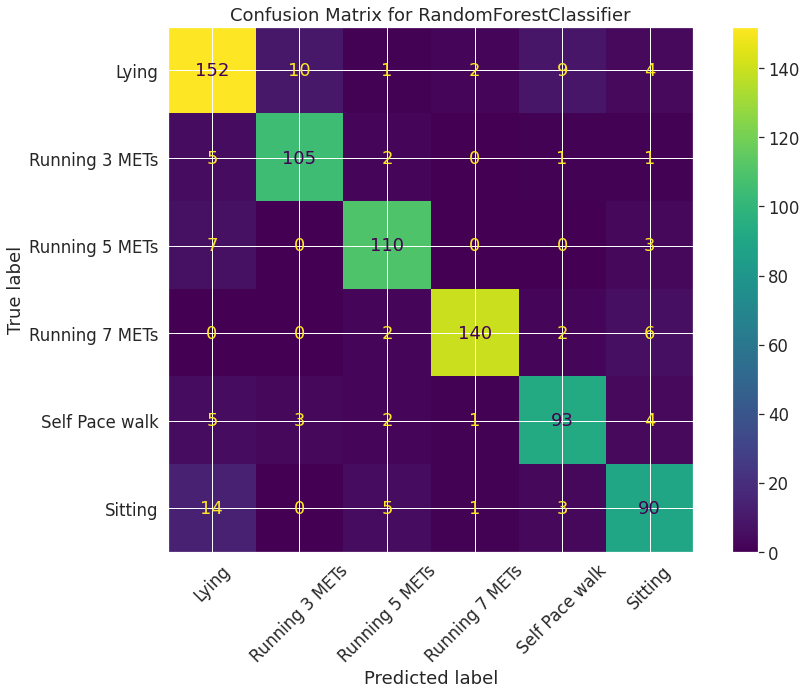

In [56]:
rf_model.display_confusion_matrix(1.5 , (13,10))

The Random Forest showed an 89% accuracy on the validation set with a 0.95 precision and 0.95 recall on the 7 Mets activity on the fitbit data. Interestingly, the fitbit data showed steps and calories to be the most important features where as Apple Watch showed variables related to heart rate.

 <font size="5"> KNN Pipeline Fitbit</font> 

In [57]:
parameters = {'clf__n_neighbors':list(range(3,15,1)),'clf__metric':['euclidean']}
steps = [('scale',StandardScaler()),('KNN',KNeighborsClassifier())]

knn_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,KNeighborsClassifier())
knn_model.create_pipeline()
grid_cv = knn_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)


In [58]:
knn_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.77      0.80      0.79       178
Running 3 METs       0.81      0.84      0.82       114
Running 5 METs       0.82      0.88      0.85       120
Running 7 METs       0.85      0.79      0.82       150
Self Pace walk       0.80      0.81      0.81       108
       Sitting       0.76      0.68      0.72       113

      accuracy                           0.80       783
     macro avg       0.80      0.80      0.80       783
  weighted avg       0.80      0.80      0.80       783



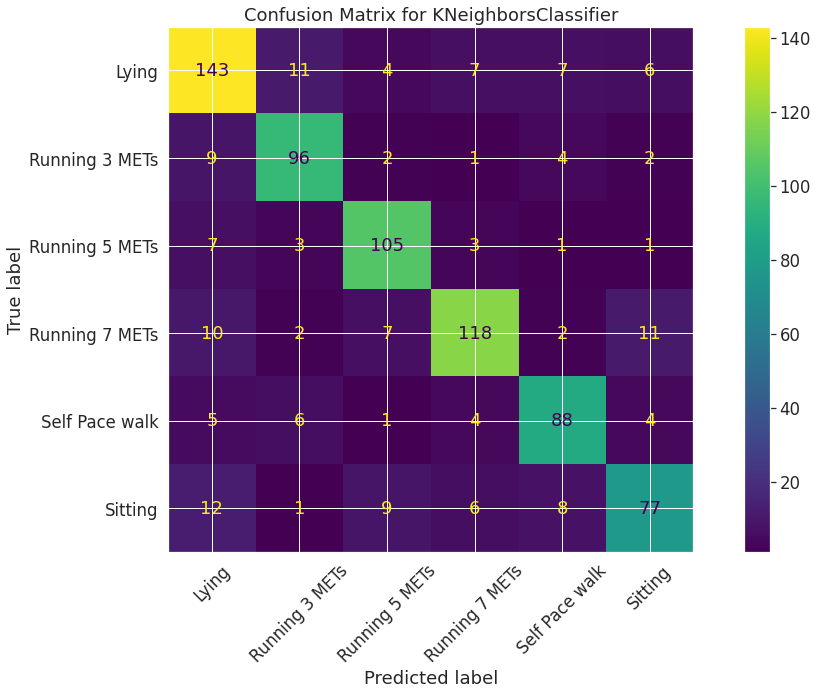

In [59]:
knn_model.display_confusion_matrix(1.5, (15,10))

On the Fitbit data KNN achieved an accuracy of 80% on the validation data set.

 <font size="5"> Naive Bayes Pipeline Fitbit</font> 

In [60]:
parameters = {'clf__var_smoothing':[.1,.15,0.5]}
steps = [('scale',StandardScaler())]
nb_model  = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,GaussianNB())
nb_model.create_pipeline(steps = steps)
grid_cv = nb_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)

In [61]:
nb_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.48      0.62      0.54       178
Running 3 METs       0.28      0.72      0.40       114
Running 5 METs       0.42      0.18      0.26       120
Running 7 METs       0.39      0.18      0.25       150
Self Pace walk       0.28      0.10      0.15       108
       Sitting       0.12      0.10      0.11       113

      accuracy                           0.34       783
     macro avg       0.33      0.32      0.28       783
  weighted avg       0.34      0.34      0.30       783



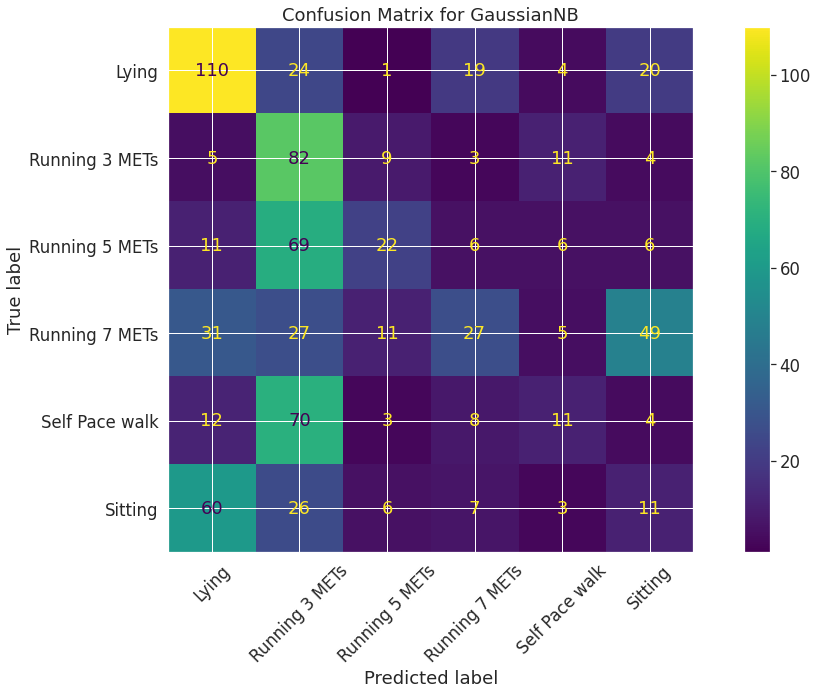

In [62]:
nb_model.display_confusion_matrix(1.5, (15,10))

The Naive Bayes does very poorly on the Fitbit data as well

 <font size="5"> Gradient Boost Pipeline Fitbit</font> 

In [63]:
parameters = {'clf__n_estimators':[200,250] , 'clf__learning_rate':[0.5,0.1],'clf__max_features':["sqrt"], 'clf__max_depth':[10,5]}
g_boost_clf = GradientBoostingClassifier()
g_boost_model = ClassifierPipeLine( X_train, y_train ,  X_test, y_test,g_boost_clf)
g_boost_model.create_pipeline()
grid_cv = g_boost_model.create_grid_search(param_grid = parameters , cv =5 , scoring = 'accuracy',output = True)


In [64]:
g_boost_model.display_classification_report()

                precision    recall  f1-score   support

         Lying       0.83      0.88      0.85       178
Running 3 METs       0.91      0.93      0.92       114
Running 5 METs       0.90      0.93      0.91       120
Running 7 METs       0.97      0.95      0.96       150
Self Pace walk       0.92      0.84      0.88       108
       Sitting       0.87      0.83      0.85       113

      accuracy                           0.90       783
     macro avg       0.90      0.89      0.90       783
  weighted avg       0.90      0.90      0.90       783



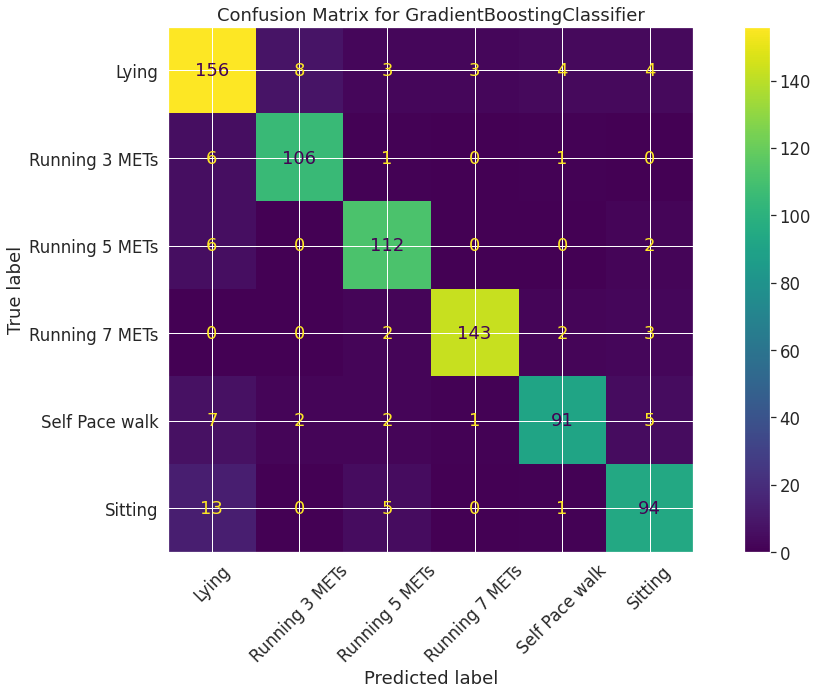

In [65]:
g_boost_model.display_confusion_matrix(1.5,(15,10))

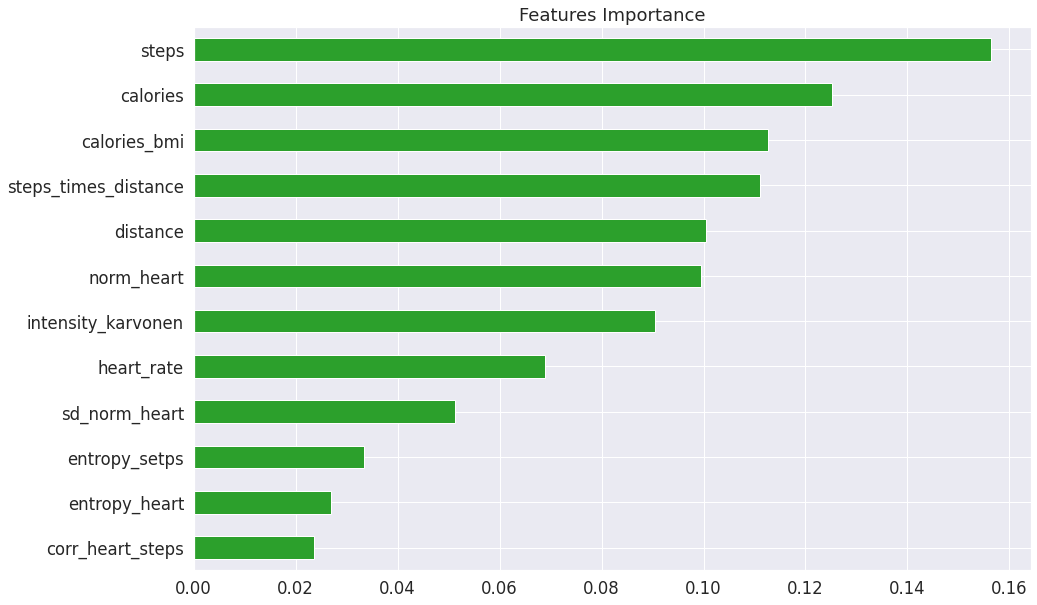

In [66]:
grid_cv.best_params_
gb_params = {key[5:]:val for key,val in grid_cv.best_params_.items()}
gb = RandomForestClassifier()
gb.set_params(**rf_params)
gb.fit(X_train,y_train)

importances = pd.Series(data=gb.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize = (15,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='#2ca02c')
plt.title('Features Importance')
plt.show()

The Gradient Boost again seems to perform the best on the Fitbit data with a 90% accuracy and high precision and recall on the Running 7 Mets Category. Again, the feature importance shows steps and calories to be the most important which is not what we saw with the Apple Watch data.

 <font size="5"> Final Thoughts</font> 

The EDA showed a lot of noise in many of the variables in the predictor space

Interestingly, the ensemble models Random Forest and Gradient Boosting performed well on accurately predicting the activity in the validation data set. On both the Fitbit and Apple Watch data the best performance was from the Gradient Boost model with around 90 and 84 percent accuracy respectively. The plus side of using the Stochastic Gradient Boost (when each weak classifier is limited in the predictors it can choose) is that we get to look at the variable importance feature. This also true of the Random Forest model.

We saw that the feature importance varied between the data collected on Apple Watch and Fitbit. It seems the ensemble models preferred the steps and calories on the Fitbit data and the heart rate related variables on the Apple Watch data. 

It would be interesting to see how these models would fair if the same data was collected using more current versions of these devices.
 
